In [1]:
# Import libraries
import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import trustworthiness

In [2]:
# Set larger font sizes for better readability in Jupyter Notebook
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})

## Dimensionality Reduction analysis for unfiltered MCF7 SmartSeq dataset

In the following notebook, we will compare different dimensionality reduction techniques on the unfiltered MCF7 SmartSeq dataset to evalaute to what extent the sparse and unprocessed data can be converted to a format suitable for clustering and, possibly also, for supervised classification.

In [3]:
# Load data
df = pd.read_csv("SmartSeq/MCF7_SmartS_Unfiltered_Data.txt",
                 delim_whitespace=True,
                 header=0,
                 quotechar='"',
                 index_col=0,
                 engine="python")

print("Original data shape (genes x samples):", df.shape)

# Transpose the data so that rows are samples and columns are genes/features
X = df.T.values
print("Transposed data shape (samples x features):", X.shape)

C:\Users\flamo\AppData\Local\Temp\ipykernel_13180\1522220954.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("SmartSeq/MCF7_SmartS_Unfiltered_Data.txt",


Original data shape (genes x samples): (22934, 383)
Transposed data shape (samples x features): (383, 22934)


In [4]:
# Extract condition information from column names
sample_names = df.columns
conditions = []
for name in sample_names:
    if "Norm" in name:
        conditions.append("Norm")
    elif "Hypo" in name:
        conditions.append("Hypo")
    else:
        conditions.append("Unknown")

# Create condition color mapping
colors = ["blue" if c == "Norm" else "red" if c == "Hypo" else "gray" for c in conditions]
condition_labels = np.array([0 if c == "Norm" else 1 if c == "Hypo" else 2 for c in conditions])

In [5]:
# Function to compute various evaluation metrics for dimensionality reduction
def evaluate_embeddings(original_data, embedding, labels):
    
    results = {}

    # 1. Silhouette score (higher is better)
    try:
        silhouette = silhouette_score(embedding, labels)
        results['silhouette_score'] = silhouette
    except:
        results['silhouette_score'] = np.nan
        
    results['trustworthiness'] = trustworthiness(original_data, embedding, n_neighbors = 5) 

    # from sklearn.manifold import trustworthiness
    #     trust = trustworthiness(X_train_U, embedding, n_neighbors=5)

    return results

### Preliminary analysis of variance using PCA shows first 25s0 PCs include more than 95% of dataset variance --> dimensionality reduction is likely to be very useful for performance, despite obviously loss of features' interpretability

In [8]:
#standardizing the data since both PCA and TSNE are sensitive to different scales for the varaince of different features
standard_scaler = StandardScaler()
X_std = standard_scaler.fit_transform(X)

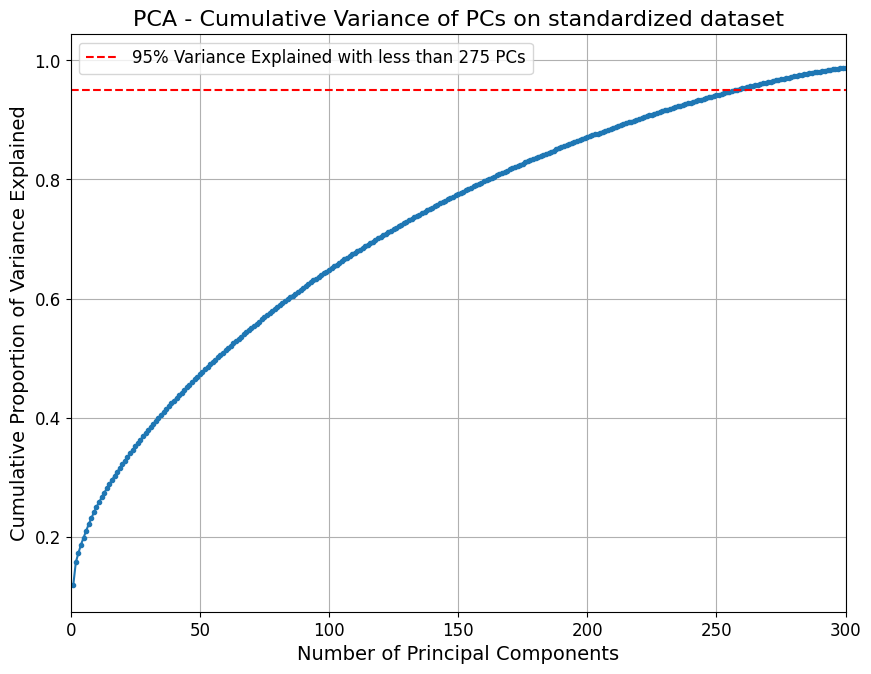

In [8]:
#after std, still 100 PCs  out of 383 possilbe explain more than 95% variance
pca_std = PCA(random_state=42)
pca_std.fit(X_std)
cumulative_variance = np.cumsum(pca_std.explained_variance_ratio_)

# Step 4: Plot
plt.figure(figsize=(10, 7.5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker=".", linestyle='-')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Variance Explained with less than 275 PCs')  # Red horizontal line
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.title('PCA - Cumulative Variance of PCs on standardized dataset')
plt.xlim(0,300)
plt.grid(True)
plt.legend()
plt.show()

## Parameter optimisation for UMAP and TSNE algorithms

In this section, we try to select the best UMAP and TSNE parameters by choosing those that preserve at best the local structure of the dataset, maximise the trustworthiness metric.

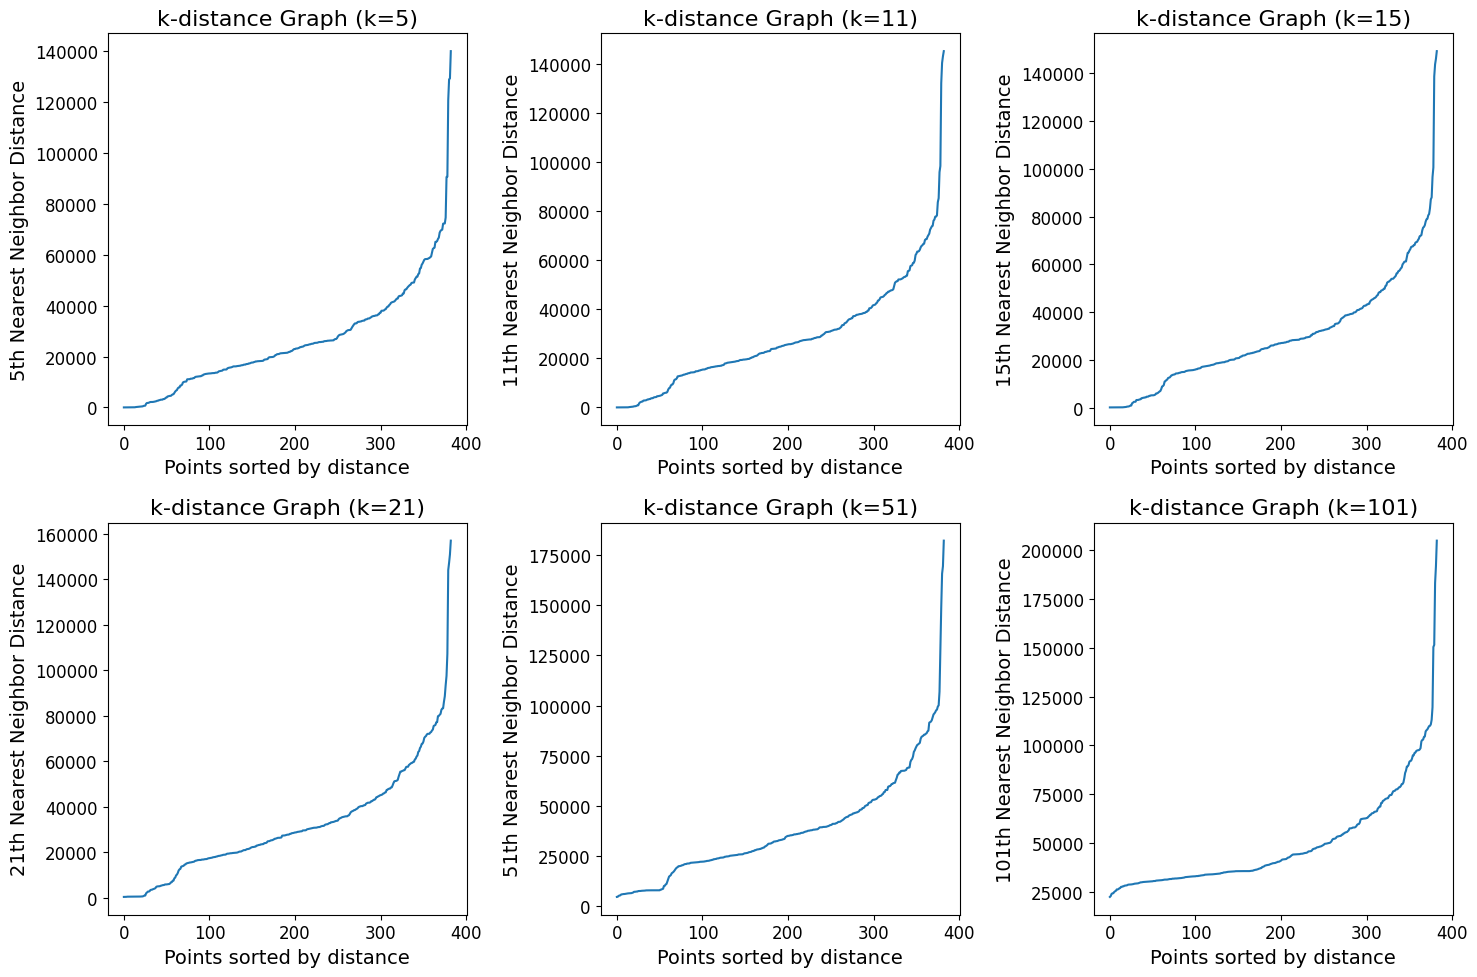

In [9]:
k_values = [ 5, 11, 15, 21, 51, 101]
#us ealos knn score
# Step 3: Create subplots for each k-distance graph
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, k in enumerate(k_values):
    # Fit NearestNeighbors
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    
    # Get distances to k-th nearest neighbor
    distances, indices = neighbors_fit.kneighbors(X)
    sorted_distances = np.sort(distances[:, k - 1])  # k-1 for zero-indexed column

    # Plot the k-distance graph
    axs[i].plot(sorted_distances)
    axs[i].set_title(f'k-distance Graph (k={k})')
    axs[i].set_xlabel('Points sorted by distance')
    axs[i].set_ylabel(f'{k}th Nearest Neighbor Distance')

# Step 4: Adjust layout
plt.tight_layout()
plt.show()

K-Distance Graphs for neighbour selection in trustworthiness score:

k-distance graphs help in understanding the local density of the dataset. 
A sharp increase in distance (i.e., when the graph flattens suddenly) indicates a possible change from dense clusters to sparse regions, which can help inform the optimal value for n_neighbors in trustworhtiness score or the level of "granularity" (i.e. how fine the unit grid of space is) of the dataset.

A small value for n_neighbors focuses on local structure (fine details) while a large value for n_neighbors captures more global structure, potentially leading to smoother embeddings but possibly losing fine details.

### In our analysis, we choose to preserve more the local structure of the dataset instead of the global one, by selecting a small number of neighbours for the trustworthiness metric, namely 5 (as also indicated by best "elbow" in nearest neighbour graph), since the high-diemnsional dataset is likely to be sparse (overall datapoints arrangement might be misleading). The latter is then used to optimise the best performing parameters of UMAP and TSNE for (a local) trustworthiness.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

# Define trustworthiness-based scoring function
def trustworthiness_scorer(estimator, X):
    X_embedded = estimator.named_steps['umap'].fit_transform(X)
    return trustworthiness(X, X_embedded, n_neighbors=5)

# Define pipeline: UMAP followed by nothing (or you can later add KMeans if needed)
pipe = Pipeline([
    ('umap', umap.UMAP(random_state=42))
])

# Parameter distribution using pipeline parameter names
param_dist = {
    'umap__n_neighbors': np.arange(5, 40),
    'umap__min_dist': np.linspace(0.0, 1, 50),
    'umap__metric': ['correlation', 'cosine'],
}

# Run RandomizedSearchCV using trustworthiness
search_U_T = RandomizedSearchCV( pipe,  param_distributions=param_dist, n_iter=100, cv=5, verbose=1, scoring=trustworthiness_scorer, random_state=22)

# Fit to data
search_U_T.fit(X)

# Print best parameters and best score
print("Best UMAP params:")
print(search_U_T.best_params_)
print(f"Best trustworthiness score: {search_U_T.best_score_:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to '

Best UMAP params:
{'umap__n_neighbors': 26, 'umap__min_dist': 0.5306122448979591, 'umap__metric': 'correlation'}
Best trustworthiness score: 0.7388


In [14]:
# Custom function to compute t-SNE and return trustworthiness
def evaluate_tsne_trustworthiness(X, n_components, perplexity, learning_rate, max_iter):
    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        learning_rate=learning_rate,
        max_iter=max_iter,
        random_state=10
    )
    X_embedded = tsne.fit_transform(X)
    trust = trustworthiness(X, X_embedded, n_neighbors=5)  # You can adjust n_neighbors
    return trust

# Define parameter ranges
n_components_range = [2, 3]
perplexity_range = np.arange(5, 51, 5)  # 5 to 50
learning_rate_range = np.logspace(-2, 2, 5)  # 0.01 to 100
max_iter_range = [250, 500, 1000]

# Number of random combinations to try
n_iter = 500

# Store results
results = []

# Random parameter search
for _ in range(n_iter):
    n_components = np.random.choice(n_components_range)
    perplexity = np.random.choice(perplexity_range)
    learning_rate = np.random.choice(learning_rate_range)
    max_iter_val = np.random.choice(max_iter_range)

    trust = evaluate_tsne_trustworthiness(
        X, n_components, perplexity, learning_rate, max_iter_val
    )
    results.append({
        'n_components': n_components,
        'perplexity': perplexity,
        'learning_rate': learning_rate,
        'max_iter': max_iter_val,
        'trustworthiness': trust
    })
    print(f"Iteration completed - Trustworthiness: {trust:.4f}")

# Find best parameters
best_result = max(results, key=lambda x: x['trustworthiness'])
print("\nBest parameters (by trustworthiness):")
print(f"t-SNE n_components: {best_result['n_components']}")
print(f"t-SNE perplexity: {best_result['perplexity']}")
print(f"t-SNE learning_rate: {best_result['learning_rate']}")
print(f"t-SNE max_iter: {best_result['max_iter']}")
print(f"Trustworthiness: {best_result['trustworthiness']:.4f}")

Iteration completed - Trustworthiness: 0.9774
Iteration completed - Trustworthiness: 0.9804
Iteration completed - Trustworthiness: 0.9712
Iteration completed - Trustworthiness: 0.9282
Iteration completed - Trustworthiness: 0.9694
Iteration completed - Trustworthiness: 0.9240
Iteration completed - Trustworthiness: 0.9327
Iteration completed - Trustworthiness: 0.9336
Iteration completed - Trustworthiness: 0.9727
Iteration completed - Trustworthiness: 0.9719
Iteration completed - Trustworthiness: 0.9341
Iteration completed - Trustworthiness: 0.9714
Iteration completed - Trustworthiness: 0.9730
Iteration completed - Trustworthiness: 0.8011
Iteration completed - Trustworthiness: 0.9804
Iteration completed - Trustworthiness: 0.9283
Iteration completed - Trustworthiness: 0.9765
Iteration completed - Trustworthiness: 0.9633
Iteration completed - Trustworthiness: 0.9693
Iteration completed - Trustworthiness: 0.9323
Iteration completed - Trustworthiness: 0.9809
Iteration completed - Trustworthin

## Plotting results of Dimensionality Reduction with best parameters

In [15]:
# Compute UMAP 2D embedding
umap_2d = umap.UMAP(n_neighbors=26, min_dist=0.53, metric = "correlation", n_components=2, random_state=42)
umap_embedding_2d = umap_2d.fit_transform(X)

c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [16]:
# Compute UMAP 3D embedding
umap_3d = umap.UMAP(n_neighbors=26, min_dist=0.53, metric="correlation", n_components=3, random_state=42)
umap_embedding_3d = umap_3d.fit_transform(X)

c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# Compute t-SNE 2D embedding
print("Computing t-SNE 2D...")
tsne_2d = TSNE(n_components=2, perplexity=35, learning_rate=10, n_iter=1000, random_state=42)
tsne_embedding_2d = tsne_2d.fit_transform(X)

Computing t-SNE 2D...


c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [18]:
# Compute t-SNE 3D embedding
print("Computing t-SNE 3D...")
tsne_3d = TSNE(n_components=3, perplexity=35, learning_rate=10, n_iter=1000, random_state=42)
tsne_embedding_3d = tsne_3d.fit_transform(X)

Computing t-SNE 3D...


c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [19]:
# Compute PCA 2D embedding
print("Computing PCA 2D...")
pca = PCA(n_components=2, random_state=42)
pca_embedding_2d = pca.fit_transform(X_std)

Computing PCA 2D...


In [20]:
# Compute PCA 3D embedding
print("Computing PCA 3D...")
pca_3d = PCA(n_components=3, random_state=42)
pca_embedding_3d = pca_3d.fit_transform(X_std)

Computing PCA 3D...


In [21]:
# Create legend elements for all plots
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=12, label='Norm'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=12, label='Hypo')
]

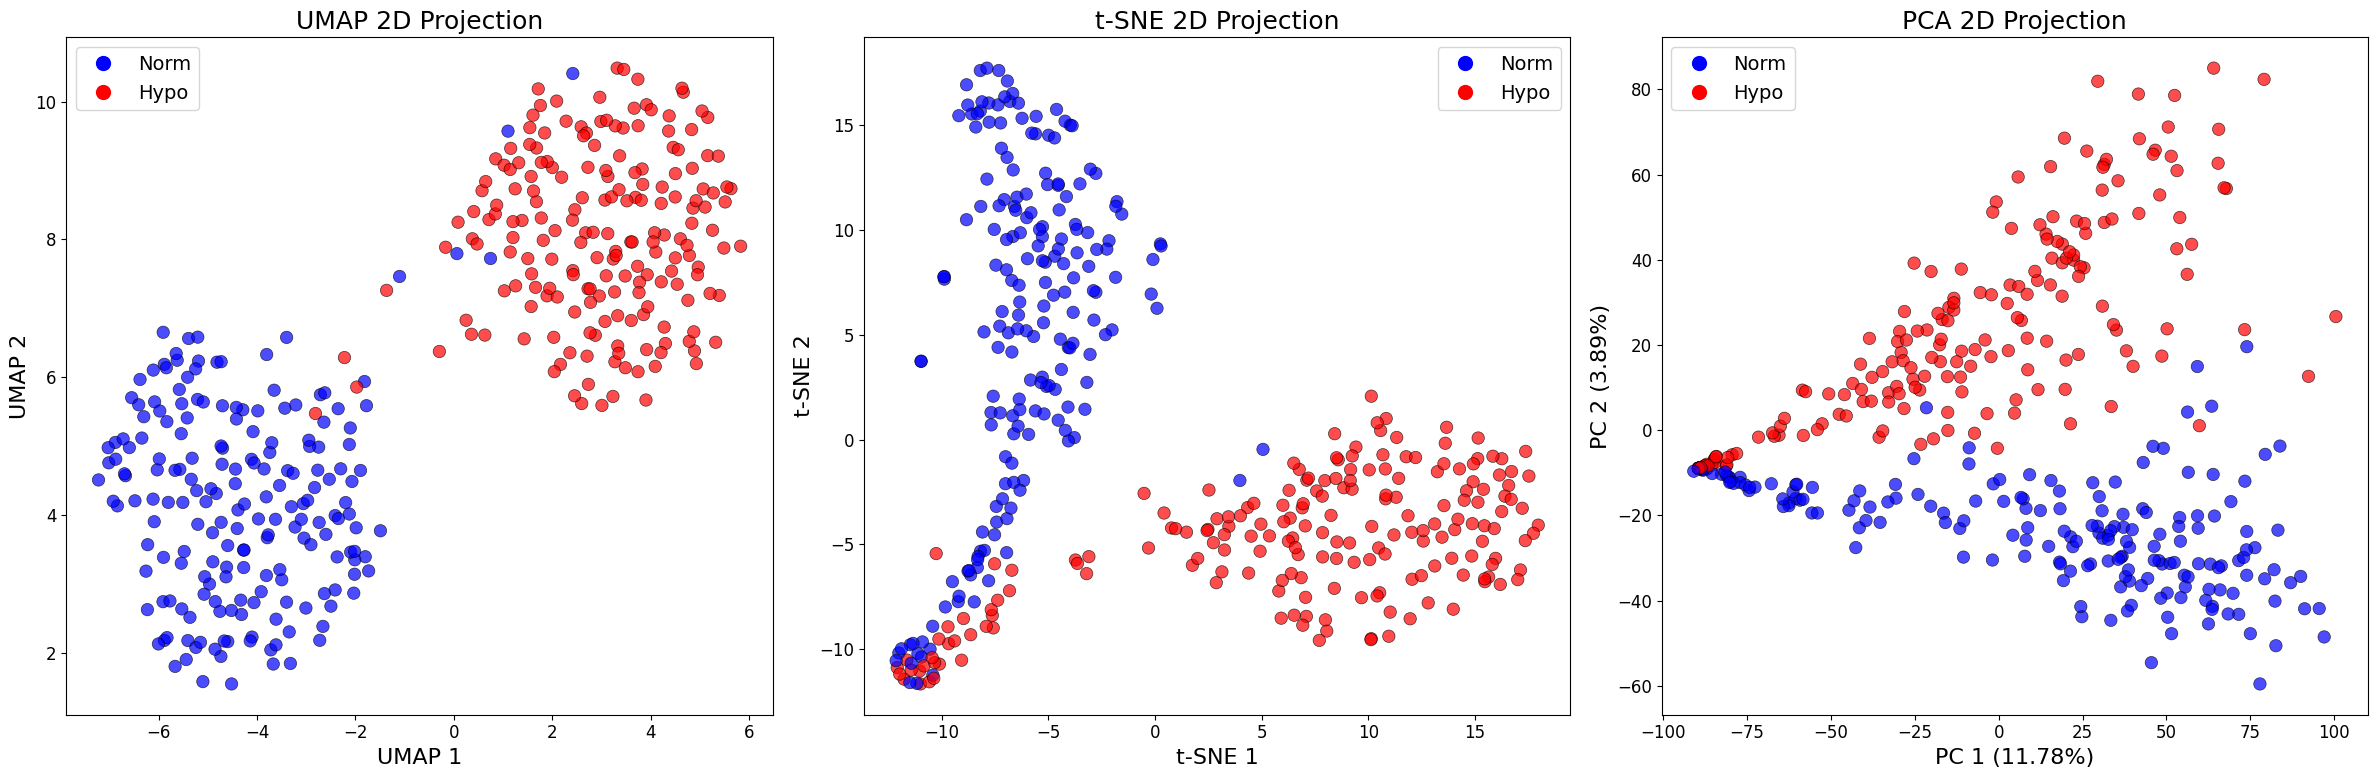

In [22]:
# Visualize 2D projections side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# UMAP 2D
axes[0].scatter(umap_embedding_2d[:, 0], umap_embedding_2d[:, 1], s=80, alpha=0.7, c=colors, edgecolor='k', linewidth=0.5)
axes[0].set_xlabel("UMAP 1", fontsize=16)
axes[0].set_ylabel("UMAP 2", fontsize=16)
axes[0].set_title("UMAP 2D Projection", fontsize=18)
axes[0].legend(handles=legend_elements, loc='best', fontsize=14)

# t-SNE 2D
axes[1].scatter(tsne_embedding_2d[:, 0], tsne_embedding_2d[:, 1], s=80, alpha=0.7, c=colors, edgecolor='k', linewidth=0.5)
axes[1].set_xlabel("t-SNE 1", fontsize=16)
axes[1].set_ylabel("t-SNE 2", fontsize=16)
axes[1].set_title("t-SNE 2D Projection", fontsize=18)
axes[1].legend(handles=legend_elements, loc='best', fontsize=14)

# PCA 2D
axes[2].scatter(pca_embedding_2d[:, 0], pca_embedding_2d[:, 1], s=80, alpha=0.7, c=colors, edgecolor='k', linewidth=0.5)
axes[2].set_xlabel(f"PC 1 ({pca.explained_variance_ratio_[0]:.2%})", fontsize=16)
axes[2].set_ylabel(f"PC 2 ({pca.explained_variance_ratio_[1]:.2%})", fontsize=16)
axes[2].set_title("PCA 2D Projection", fontsize=18)
axes[2].legend(handles=legend_elements, loc='best', fontsize=14)

plt.tight_layout()
plt.savefig("comparison_2d_projections.png", dpi=300)
plt.show()

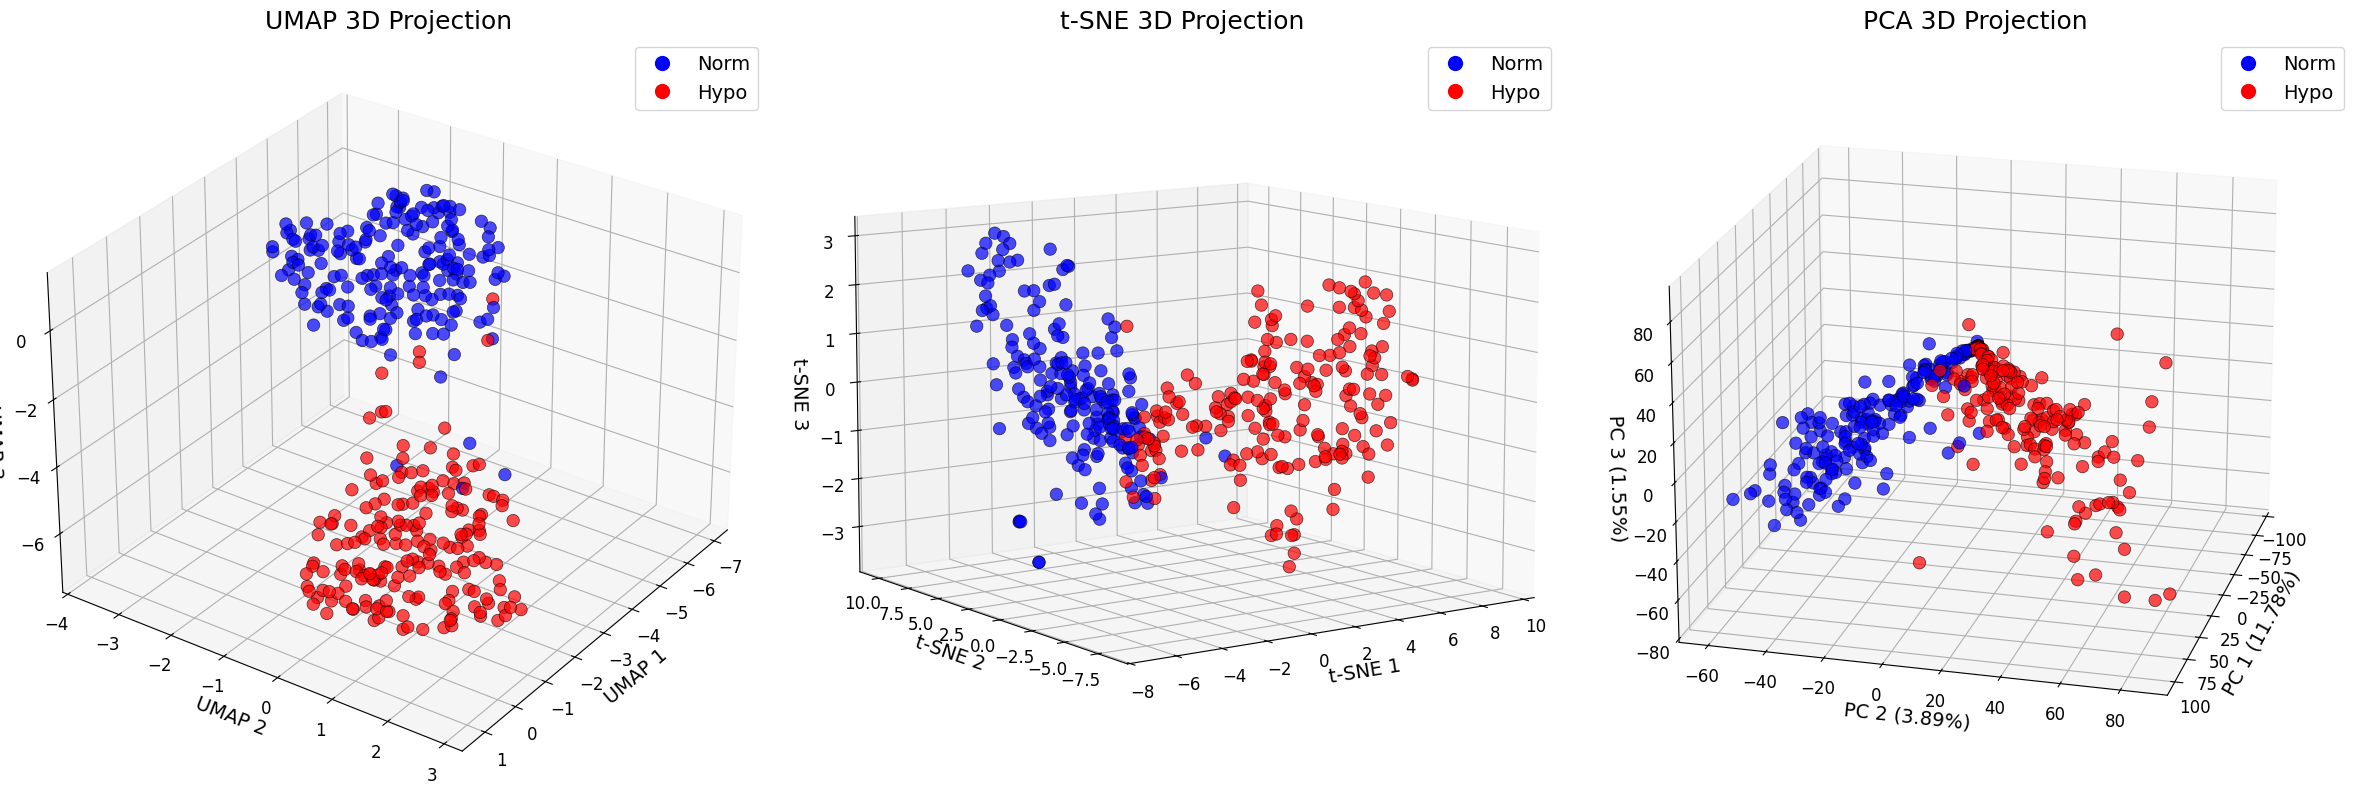

In [23]:
# Visualize 3D projections side by side
fig = plt.figure(figsize=(24, 8))

# UMAP 3D
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(
    umap_embedding_3d[:, 0],
    umap_embedding_3d[:, 1],
    umap_embedding_3d[:, 2],
    c=colors, s=80, alpha=0.7, edgecolor='k', linewidth=0.5
)
ax1.set_xlabel("UMAP 1", fontsize=14)
ax1.set_ylabel("UMAP 2", fontsize=14)
ax1.set_zlabel("UMAP 3", fontsize=14)
ax1.set_title("UMAP 3D Projection", fontsize=18)
ax1.view_init(elev=30, azim=35)
ax1.legend(handles=legend_elements, loc='upper right', fontsize=14)

# t-SNE 3D
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(
    tsne_embedding_3d[:, 0],
    tsne_embedding_3d[:, 1],
    tsne_embedding_3d[:, 2],
    c=colors, s=80, alpha=0.7, edgecolor='k', linewidth=0.5
)
ax2.set_xlabel("t-SNE 1", fontsize=14)
ax2.set_ylabel("t-SNE 2", fontsize=14)
ax2.set_zlabel("t-SNE 3", fontsize=14)
ax2.set_title("t-SNE 3D Projection", fontsize=18)
ax2.view_init(elev=10, azim=235)
ax2.legend(handles=legend_elements, loc='upper right', fontsize=14)

# PCA 3D
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(
    pca_embedding_3d[:, 0],
    pca_embedding_3d[:, 1],
    pca_embedding_3d[:, 2],
    c=colors, s=80, alpha=0.7, edgecolor='k', linewidth=0.5
)
ax3.set_xlabel(f"PC 1 ({pca_3d.explained_variance_ratio_[0]:.2%})", fontsize=14)
ax3.set_ylabel(f"PC 2 ({pca_3d.explained_variance_ratio_[1]:.2%})", fontsize=14)
ax3.set_zlabel(f"PC 3 ({pca_3d.explained_variance_ratio_[2]:.2%})", fontsize=14)
ax3.set_title("PCA 3D Projection", fontsize=18)
ax3.view_init(elev=20, azim=15)
ax3.legend(handles=legend_elements, loc='upper right', fontsize=14)

plt.tight_layout()
plt.savefig("comparison_3d_projections.png", dpi=300)
plt.show()

## EVALUATION of PCA, UMAP and TSNE

In [24]:
# Evaluate each method
print("Evaluating methods...")
# Filter out any Unknown conditions
valid_indices = [i for i, c in enumerate(conditions) if c != "Unknown"]
valid_labels = condition_labels[valid_indices]
valid_X = X[valid_indices]
valid_X_std = X_std[valid_indices]

Evaluating methods...


In [25]:
# Evaluate 2D embeddings
umap_2d_metrics = evaluate_embeddings(valid_X, umap_embedding_2d[valid_indices], valid_labels)
tsne_2d_metrics = evaluate_embeddings(valid_X, tsne_embedding_2d[valid_indices], valid_labels)
pca_2d_metrics = evaluate_embeddings(valid_X_std, pca_embedding_2d[valid_indices], valid_labels)

In [26]:
# Evaluate 3D embeddings
umap_3d_metrics = evaluate_embeddings(valid_X, umap_embedding_3d[valid_indices], valid_labels)
tsne_3d_metrics = evaluate_embeddings(valid_X, tsne_embedding_3d[valid_indices], valid_labels)
pca_3d_metrics = evaluate_embeddings(valid_X_std, pca_embedding_3d[valid_indices], valid_labels)

In [27]:
# Combine results
all_metrics = {
    "UMAP 2D": umap_2d_metrics,
    "t-SNE 2D": tsne_2d_metrics,
    "PCA 2D": pca_2d_metrics,
    "UMAP 3D": umap_3d_metrics,
    "t-SNE 3D": tsne_3d_metrics,
    "PCA 3D": pca_3d_metrics
}

# Convert to DataFrame for easier comparison
metrics_df = pd.DataFrame(all_metrics).T
print("\nComparison of Dimensionality Reduction Methods:")
print(metrics_df)


Comparison of Dimensionality Reduction Methods:
          silhouette_score  trustworthiness
UMAP 2D           0.671003         0.714295
t-SNE 2D          0.459485         0.972521
PCA 2D            0.234926         0.588019
UMAP 3D           0.623251         0.736746
t-SNE 3D          0.400658         0.982368
PCA 3D            0.203937         0.614546


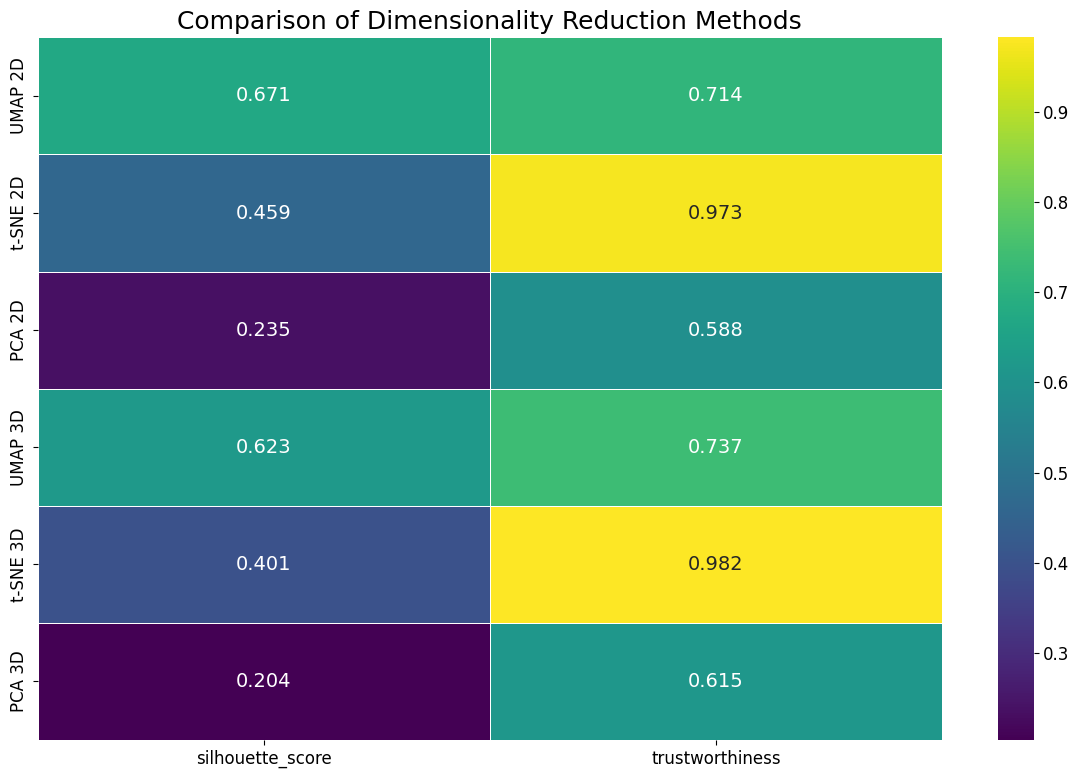

In [28]:
# Create a heatmap to visualize the comparison
plt.figure(figsize=(12, 8))
sns.heatmap(metrics_df, annot=True, cmap="viridis", linewidths=.5, fmt=".3f")
plt.title("Comparison of Dimensionality Reduction Methods", fontsize=18)
plt.tight_layout()
plt.savefig("method_comparison_heatmap.png", dpi=300)
plt.show()

In [29]:
# Calculate an overall score (weighted average of normalized metrics)
# Note: Higher is better for silhouette and trustworthiness, lower is better for Davies-Bouldin
# Normalize metrics to 0-1 scale
normalized_metrics = metrics_df.copy()

# For metrics where higher is better
for metric in ['silhouette_score']:
    min_val = normalized_metrics[metric].min()
    max_val = normalized_metrics[metric].max()
    if max_val > min_val:
        normalized_metrics[metric] = (normalized_metrics[metric] + 1) / 2

In [30]:
# Define weights for each metric (can be adjusted based on importance) 
# cannot really work beacuse Davis-Boulding score is unbounded and others have different ranges so first normalisation to (0,1) is necessary 
weights = {
    'silhouette_score': 0.5,  # Measures cluster separation
    'trustworthiness': 0.5,  # Measures preservation of local structure
}

# Calculate weighted score
normalized_metrics['weighted_score'] = sum(normalized_metrics[metric] * weight
                                          for metric, weight in weights.items())

# Sort by weighted score
normalized_metrics = normalized_metrics.sort_values('weighted_score', ascending=False)

print("\nRanking of Methods (higher is better):")
print(normalized_metrics[['weighted_score']])


Ranking of Methods (higher is better):
          weighted_score
t-SNE 2D        0.851132
t-SNE 3D        0.841349
UMAP 2D         0.774898
UMAP 3D         0.774186
PCA 3D          0.608257
PCA 2D          0.602741


<Figure size 1200x800 with 0 Axes>

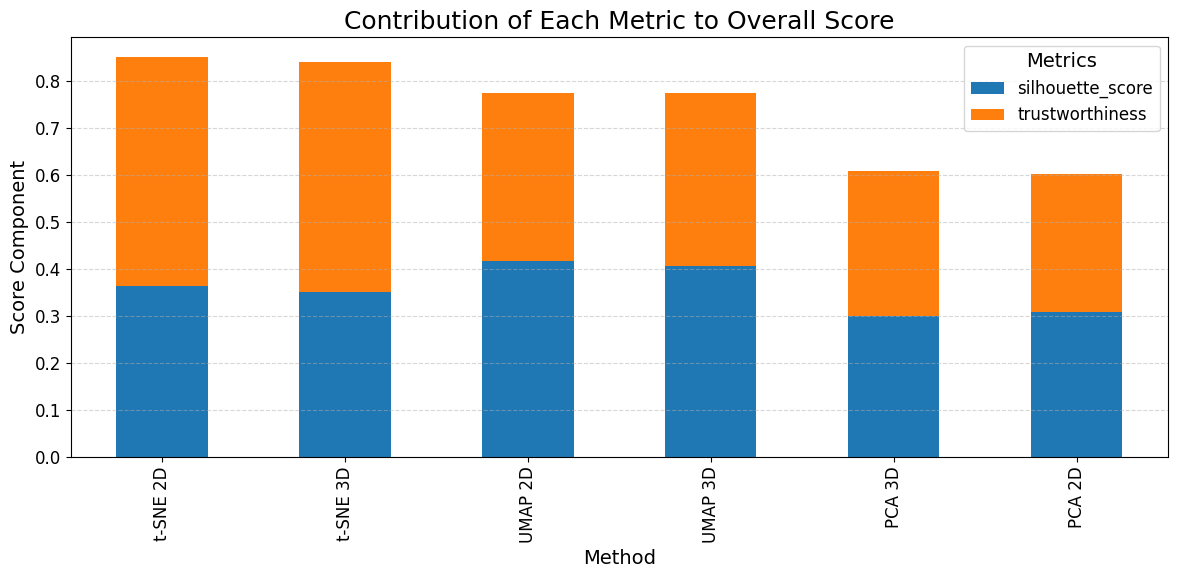

In [31]:
# Additional visualization: Contribution of each metric to overall score
contribution_df = pd.DataFrame({
    metric: normalized_metrics[metric] * weight
    for metric, weight in weights.items()
}, index=normalized_metrics.index)

plt.figure(figsize=(12, 8))
contribution_df.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Contribution of Each Metric to Overall Score', fontsize=18)
plt.xlabel('Method')
plt.ylabel('Score Component')
plt.legend(title='Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
#plt.savefig("score_components.png", dpi=300)
plt.show()

## BONUS: AUTOENCODER

Optimising UMAP parameters by minimising the reconstruction error of the pipeline (UMAP + Decoder NN, which should learn an inverse UMAP tranform) 

This was just performed as an experiment to see how complex the task of learning an inverse UMAP transform is for a Neural Network and how much the latter is influenced by how deep the NN is. We try a rudimentary decoder with only 2 layers of increasing size and relu activation.

In [6]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from scipy.stats import randint, uniform

FIrst, we standrdise the data and clean it using Kevin's preprocessing

In [11]:
# Split and normalize data
X_train, X_test = train_test_split(X_std, test_size=0.2, random_state=42)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Define parameter search space for UMAP
# param_distributions = {
#     'n_neighbors': randint(5, 50),
#     'min_dist': uniform(0.0, 0.5),
#     'metric': ['correlation', 'cosine']
# }

param_distributions = {
    'umap__n_neighbors': np.arange(5, 40),
    'umap__min_dist': np.linspace(0.0, 0.5, 50),
    'umap__metric': ['correlation', 'cosine'],
}

def build_decoder(input_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Random search
best_loss = float('inf')
best_params = None
best_decoder = None
best_embedding_train = None
n_iter = 10
embedding_dim = 50

for _ in range(n_iter):
    # Sample UMAP params
    # params = {
    #     k: np.random.choice(v) if isinstance(v, list) else v.rvs()
    #     for k, v in param_distributions.items()
    # }
    params = { 
        'n_neighbors': np.random.choice(param_distributions["umap__n_neighbors"]),
        'min_dist': np.random.choice(param_distributions["umap__min_dist"]),
        'metric': np.random.choice(param_distributions["umap__metric"]),
    }
    params['n_neighbors'] = int(params['n_neighbors'])

    # Fit UMAP with sampled params
    reducer = umap.UMAP(n_components=embedding_dim, random_state=42, **params)
    embedding_train = reducer.fit_transform(X_train)
    embedding_test = reducer.transform(X_test)

    # Train decoder to reconstruct original data
    decoder = build_decoder(embedding_dim, X_train.shape[1])
    decoder.fit(embedding_train, X_train,
                epochs=100,
                batch_size=500,
                validation_split=0.1,
                shuffle = True,
                verbose=0)

    # Evaluate reconstruction on test set
    X_reconstructed = decoder.predict(embedding_test)
    loss = mean_squared_error(X_test, X_reconstructed)

    print(f"Params: {params}, Reconstruction MSE: {loss:.4f}")

    if loss < best_loss:
        best_loss = loss
        best_params = params
        best_decoder = decoder
        best_embedding_train = embedding_train

c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regu

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Params: {'n_neighbors': 7, 'min_dist': 0.4183673469387755, 'metric': 'cosine'}, Reconstruction MSE: 0.7889


c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regu

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Params: {'n_neighbors': 22, 'min_dist': 0.08163265306122448, 'metric': 'cosine'}, Reconstruction MSE: 0.7885


c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regu

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000027E0F3CDA80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Params: {'n_neighbors': 15, 'min_dist': 0.22448979591836732, 'metric': 'cosine'}, Reconstruction MSE: 0.7876


c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regu

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Params: {'n_neighbors': 31, 'min_dist': 0.16326530612244897, 'metric': 'cosine'}, Reconstruction MSE: 0.7894


c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regu

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Params: {'n_neighbors': 12, 'min_dist': 0.2857142857142857, 'metric': 'correlation'}, Reconstruction MSE: 0.7873


c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regu

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Params: {'n_neighbors': 34, 'min_dist': 0.3469387755102041, 'metric': 'cosine'}, Reconstruction MSE: 0.7841


c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regu

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Params: {'n_neighbors': 15, 'min_dist': 0.3469387755102041, 'metric': 'correlation'}, Reconstruction MSE: 0.7846


c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regu

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Params: {'n_neighbors': 28, 'min_dist': 0.29591836734693877, 'metric': 'cosine'}, Reconstruction MSE: 0.7869


c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regu

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Params: {'n_neighbors': 23, 'min_dist': 0.01020408163265306, 'metric': 'cosine'}, Reconstruction MSE: 0.7870


c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\flamo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regu

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Params: {'n_neighbors': 31, 'min_dist': 0.2755102040816326, 'metric': 'correlation'}, Reconstruction MSE: 0.7889


In [12]:
print(best_loss, best_params)

0.7840561866760254 {'n_neighbors': 34, 'min_dist': 0.3469387755102041, 'metric': 'cosine'}


As can be seen from the value of the mse LOSS function, the NN decoder has not converged (since features are scaled with variance 1) both due to the small number of epochs and also probably because the decoder should be deeper and have layers with higher number of neurons. In addition, sinc the data to be reconstructed is very sparse and skewed, the taks of the inverse transform network is also considreably difficult